In [173]:
import pandas as pd
import numpy as np

In [174]:
df = pd.read_csv('fundacurrentlistings20240517_dataset.csv')

In [175]:
df = df.drop_duplicates()
df = df.drop(columns={'size', 'city', 'last_ask_price', 'insulation', 'heating', 'num_of_bathrooms'})
df = df.rename(columns={'ownership':'outside_space', 'building_type':'newbuild'})

# clean the price data
df['price'] = df['price'].str.replace('€ ', '')
df['price'] = df['price'].str.replace(' /mnd', '')
df['price'] = df['price'].str.replace('k', '')
df['price'] = df['price'].str.replace('na', '0')
df['price'] = df['price'].str.replace('Huurprijs op aanvraag', '0')
df['price'] = df['price'].str.replace('.', '')

# dropping all listings with price = 0 as it can't be correct.
# drop the listings with price of more than 12500. Those listings are properties that are for sale and not for rent. They have been wrongly categorized.
# drop the listings with price < 500 as these are storage rooms or parking garages
df = df.drop(df[df['price'] == '0'].index)
df = df.drop(df[pd.to_numeric(df['price']) > 12500].index)
df = df.drop(df[pd.to_numeric(df['price']) < 500].index)


# clean zip_code into 'XXXX XX'
df['zip_code'] = df['zip_code'].str[:7]

# drop garage listings
df = df.drop(df[df['kind_of_house'] == 'Garage'].index)
df = df.drop(df[df['kind_of_house'] == 'Inpandige garage'].index)
df = df.drop(df[df['kind_of_house'] == 'parkeerkelder'].index)
df = df.drop(df[df['kind_of_house'] == 'Parkeerplaats'].index)

# clean the year. We changed 'Voor XXXX', 'Na XXXX' and 'XXXX-YYYY' to 'XXXX'
df['year'] = df['year'].str.replace('Voor ', '')
df['year'] = df['year'].str.replace('Na ', '')
df['year'] = df['year'].str[:4]

# impute missing data with NaN
def check_year_validity(label):
    if 0 < label < 2025:
        return label
    else:
        return np.nan

df['year'] = df['year'].astype(int).apply(check_year_validity)

def check_living_area_validity(label):
    if label != 'na':
        return label
    else:
        return np.nan

# clean living_area data
df['living_area'] = df['living_area'].str.replace(' m²', '')
df['living_area'] = df['living_area'].astype(str).apply(check_living_area_validity)

df.describe()

,year
count,887.000000
mean,1959.910936
std,91.418085
min,1005.000000
25%,1906.000000
50%,1998.000000
75%,2024.000000
max,2024.000000


In [177]:
# extract number of rooms in total
df['num_of_rooms'] = df['layout'].str.extract(r'Aantal kamers(\d+)')
# extract the number of bathrooms
df['num_of_bedrooms'] = df['layout'].str.extract(r'(\d+) slaapkamer')
# extract the number of bedrooms
df['num_of_bathrooms'] = df['layout'].str.extract(r'(\d+) badkamer')
# extract the number of seperate toilets
df['num_of_separate_toilets'] = df['layout'].str.extract(r'(\d+) apart')
# extract the floor number of house
df['floor_of_house'] = df['layout'].str.extract(r'Gelegen op(\w+)')
df['floor_of_house'] = df['floor_of_house'].str.replace('e', '')

df = df.drop(columns={'layout'})

# dummy coding the parking variable. 1 is parkinggarage is available. 0 is parkinggarage is not available
df['parking'] = df['parking'].apply(lambda x: 1 if 'Soort parkeergelegenheid' in x else 0)

# dummy code newbuild variable. 1 if property is newly built. 0 is it is an existing property
df['newbuild'] = df['newbuild'].apply(lambda x: 1 if 'Nieuwbouw' in x else 0)

# Turn the energy labels into ordinal values with NaN if value is missing
def check_energy_label(label):
    if 'A++++' in label:
        return 8
    elif 'A+++' in label:
        return 7
    elif 'A++' in label:
        return 6
    elif 'A+' in label:
        return 5
    elif 'A' in label:
        return 4
    elif 'B' in label:
        return 3
    elif 'C' in label:
        return 2
    elif 'D' in label:
        return 1
    else:
        return np.nan

df['energy_label'] = df['energy_label'].astype(str).apply(check_energy_label)

# reduce the amount of categories of the houses into more general categories
def categorize_housing_type(housing_type):
    apartments_flats = [
        'Portiekflat', 'Portiekflat (appartement met open portiek)', 'Galerijflat',
        'Galerijflat (appartement)', 'Portiekflat (appartement)', 'Tussenverdieping',
        'Bovenwoning (appartement)', 'Portiekwoning (appartement)', 'Benedenwoning (appartement)',
        'Maisonnette', 'Tussenverdieping (appartement)', 'Bovenwoning (appartement met open portiek)',
        'Benedenwoning (souterrain)', 'Benedenwoning (souterrain met open portiek)', 'Dubbel benedenhuis',
        'Maisonnette (appartement)', 'Dubbel benedenhuis (appartement)', 'Bovenwoning (dubbel bovenhuis)',
        'Benedenwoning (appartement met open portiek)', 'Tussenverdieping (appartement met open portiek)',
        'Bovenwoning (open portiek)', 'Beneden + bovenwoning (appartement met open portiek)',
        'Tussenverdieping (open portiek)', 'Beneden + bovenwoning (bel-etage)', 'Benedenwoning (bel-etage)',
        'Penthouse (appartement)', 'Dubbel benedenhuis (bel-etage)', 'Dubbel benedenhuis (appartement met open portiek)',
        'Tussenverdieping (service flat)'
    ]
    single_family_homes = [
        'Eengezinswoning, tussenwoning', 'Eengezinswoning, tussenwoning (hofjeswoning)', 
        'Eengezinswoning, geschakelde woning', 'Eengezinswoning, hoekwoning', 
        'Eengezinswoning, tussenwoning (split-level woning)', 'Eengezinswoning, tussenwoning (drive-in woning)', 
        'Eengezinswoning, 2-onder-1-kapwoning'
    ]
    duplex_multi_level_homes = [
        'Beneden + bovenwoning', 'Benedenwoning (dubbel bovenhuis)', 'Maisonnette (dubbel bovenhuis)', 
        'Dubbel benedenhuis (dubbel bovenhuis met open portiek)', 'Bovenwoning (dubbel bovenhuis met open portiek)', 
        'Beneden + bovenwoning (appartement)'
    ]
    luxury_homes = [
        'Penthouse', 'Herenhuis, tussenwoning', 'Villa, halfvrijstaande woning (waterwoning)', 
        'Landhuis, 2-onder-1-kapwoning', 'Grachtenpand, tussenwoning'
    ]
    waterfront_homes = ['Woonboot, vrijstaande woning (waterwoning)']

    if housing_type in apartments_flats:
        return 'apartments/flats'
    elif housing_type in single_family_homes:
        return 'single-family homes'
    elif housing_type in duplex_multi_level_homes:
        return 'duplex/multi-level homes'
    elif housing_type in luxury_homes:
        return 'luxury homes'
    elif housing_type in waterfront_homes:
        return 'waterfront homes'
    else:
        return np.nan

df['kind_of_house'] = df['kind_of_house'].apply(categorize_housing_type)

# dummy code if garden is present
def categorize_garden(x):
    if 'tuin' in x or 'Tuin' in x:
        return 1
    elif 'meter' in x or 'Meter' in x:
        return 1
    elif 'Patio' in x or 'patio' in x:
        return 1
    elif 'zonneterras' in x or 'Zonneterras' in x:
        return 1
    else:
        return 0

df['garden'] = df['outside_space'].apply(categorize_garden)

# dummy code balcony is balcony is available in property
def categorize_balcony(x):
    if 'Balkon' in x:
        return 1
    elif 'balkon' in x:
        return 1
    else:
        return 0

df['balcony'] = df['outside_space'].apply(categorize_balcony)

# dummy code rooftop is a rooftop is available for the tenants
def categorize_rooftop(x):
    if 'Dakterras' in x:
        return 1
    else:
        return 0

df['roof_top'] = df['outside_space'].apply(categorize_rooftop)

In [178]:
# dummy code the kind_of_house variable and add it to the dataframe
dummies = pd.get_dummies(df['kind_of_house'], prefix='type_of_home', dtype='int')
df = pd.concat([df, dummies], axis=1)

# drop the original 'kind_of_house' column as it's no longer needed
df.drop('kind_of_house', axis=1, inplace=True)

In [179]:
# for some variables, parking was present but not correctly inputted in funda, so we corrected it here
df['parking'] = df.apply(lambda row: 1 if '1 auto' in row['outside_space'] else row['parking'], axis=1)
df = df.drop(columns={'outside_space'})

# we replace blank strings where data is missing with the NaN
df[['num_of_rooms', 'energy_label', 'num_of_bedrooms', 'num_of_bathrooms', 'num_of_separate_toilets', 'floor_of_house']] = df[['num_of_rooms', 'energy_label', 'num_of_bedrooms', 'num_of_bathrooms', 'num_of_separate_toilets', 'floor_of_house']].replace('', np.nan)

# the floor_of_house are all digits, except for the ground floor. Because we did some data cleaning before, ground floor is now represented by Bgan, so we replaced Bgan to 0 as it is the 0th floor.
df['floor_of_house'] = df['floor_of_house'].replace('Bgan', 0)
df.head(20)

,url,price,address,descrip,zip_code,year,living_area,newbuild,num_of_rooms,energy_label,...,num_of_separate_toilets,floor_of_house,garden,balcony,roof_top,type_of_home_apartments/flats,type_of_home_duplex/multi-level homes,type_of_home_luxury homes,type_of_home_single-family homes,type_of_home_waterfront homes
0,https://www.funda.nl/huur/amsterdam/appartemen...,1045,Schipluidenlaan 254,Podium * VERHUUR GESTART * 147 middenhuur ...,1062 HE,2024,44,1,2,NaN,...,NaN,1,0,0,0,1,0,0,0,0
1,https://www.funda.nl/huur/amsterdam/appartemen...,1068,Krijn Taconiskade 299,*** See English version below *** Huren D...,1087 HW,2022,44,1,1,6.0,...,NaN,3,0,0,0,1,0,0,0,0
2,https://www.funda.nl/huur/amsterdam/appartemen...,1099,Haarlemmerweg,** BINNENKORT IN VERHUUR | WesterparkWest f...,1014 BL,2024,50,1,2,NaN,...,NaN,NaN,0,0,0,1,0,0,0,0
3,https://www.funda.nl/huur/amsterdam/appartemen...,1103,Krijn Taconiskade 441,*** See English version below *** Huren D...,1087 HW,2022,44,1,1,6.0,...,NaN,5,0,0,0,1,0,0,0,0
4,https://www.funda.nl/huur/amsterdam/appartemen...,1105,Willem Frogerstraat 41,Podium *VERHUUR GESTART* 147 middenhuur app...,1062 HZ,2024,56,1,2,NaN,...,NaN,1,0,0,0,1,0,0,0,0
5,https://www.funda.nl/huur/amsterdam/appartemen...,1115,Schipluidenlaan 270,Podium * VERHUUR GESTART * 147 middenhuur ...,1062 HE,2024,50,1,2,NaN,...,NaN,1,0,0,0,1,0,0,0,0
6,https://www.funda.nl/huur/amsterdam/appartemen...,1120,Staalmeesterslaan 377,"Via de website van Makelaardij Hoekstra, hu...",1057 PG,1971,58,0,2,5.0,...,NaN,13,0,0,0,1,0,0,0,0
7,https://www.funda.nl/huur/amsterdam/appartemen...,1120,Staalmeesterslaan 380,"Via de website van Makelaardij Hoekstra, hu...",1057 PG,1971,58,0,2,5.0,...,NaN,14,0,0,0,1,0,0,0,0
8,https://www.funda.nl/huur/amsterdam/appartemen...,1130,Olga de Haasstraat 513,Living the high life! *VERHUUR GESTART* Sch...,1095 PG,2024,58,1,2,NaN,...,NaN,28,0,0,0,1,0,0,0,0
9,https://www.funda.nl/huur/amsterdam/appartemen...,1135,Willem Frogerstraat 53,Podium * VERHUUR GESTART * 147 middenhuur ...,1062 HZ,2024,80,1,4,NaN,...,NaN,1,0,0,0,1,0,0,0,0


<Axes: xlabel='year', ylabel='price'>

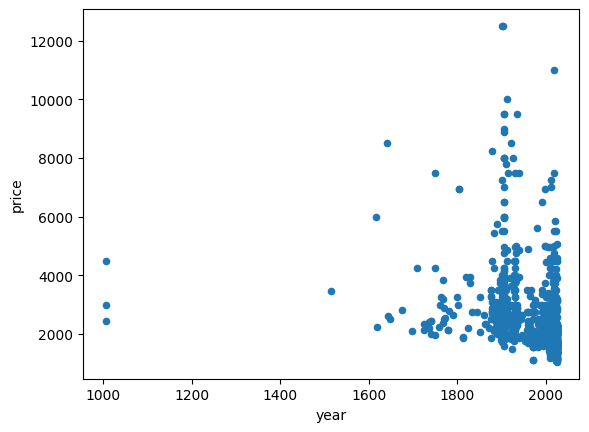

In [180]:
# df.to_csv('v12.csv', index=False)
# df.sort_values('total_num_of_floors', ascending=False, key=pd.to_numeric)

df_test = df
# df_test = df_test['living_area'].drop(df[df['living_area'] == np.nan].index)

# df_test['year'] = df_test['year'].astype(float)
# df_test['price'] = df_test['price'].astype(float)
# df_test.plot.scatter(x='year', y='price')